In [ ]:
%%javascript
IPython.notebook.clear_all_output();

In [1]:
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from glob import glob
import matplotlib.image as image
import time
# import splitfolders 

from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import tensorflow.keras.backend as Backend

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda


In [14]:
dir_name = "./data"
isDir = os.path.isdir(dir_name) 
if not isDir:
    !mkdir data
    !mkdir data/Boots data/Sandals data/Shoes data/Slippers
    !find ut-zap50k-images/Boots -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Boots;
    !find ut-zap50k-images/Sandals -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Sandals;
    !find ut-zap50k-images/Shoes -type f -name "*.jpg" | head -1500 | xargs -d '\n' mv -t data/Shoes;
    !find ut-zap50k-images/Slippers -type f -print0 | xargs -0 mv -t data/Slippers;
    !rm -rf ut-zap50k-images;

In [2]:
dir_name = "./data"

files='**/*.jpg'
filenames = glob(os.path.join(dir_name, files))
classes = [os.path.basename(os.path.dirname(name)) for name in filenames]
count = list(Counter(classes).items())
print("Class count:", count);

Class count: [('Slippers', 1283), ('Sandals', 1500), ('Boots', 1500), ('Shoes', 1500)]


In [3]:
class_names = os.listdir(dir_name) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels
print("Classes:", class_name2id)

labels = [class_name2id[c] for c in classes]
Counter(labels)

Classes: {'Slippers': 0, 'Sandals': 1, 'Boots': 2, 'Shoes': 3}


Counter({0: 1283, 1: 1500, 2: 1500, 3: 1500})

# Processing dataset

In [18]:
# split dataset into train, test and validation
splitfolders.ratio('data', output="splitted_data", seed=1337, ratio=(.8, 0.1,0.1))

In [4]:
# config
IMG_SHAPE = (102, 102, 3)
IMG_SIZE = (102, 102) 
BATCH_SIZE = 32
EPOCHS = 32

In [5]:
def get_image(filename):
    img_obj = load_img(filename, target_size=IMG_SIZE) # image object
    numpy_image = img_to_array(img_obj) # image object -> pixel array
    return numpy_image

def map_dataset(filenames):
    data = []
    for i in range(len(filenames)):
        data.append(get_image(filenames[i]))
        if(i % 1000 == 0): print(i, 'images loaded')
    return np.array(data)/255.0

def get_files_labels(path):
    files = glob(os.path.join(path, '**/*.jpg'))
    classes = [os.path.basename(os.path.dirname(name)) for name in files]
    labels = [class_name2id[c] for c in classes]
    return files, np.array(labels)
    

In [6]:
train_path = "splitted_data/train"
train_files, train_y = get_files_labels(train_path)
print("Train:", Counter(train_y))

test_path = "splitted_data/test"
test_files, test_y = get_files_labels(test_path)
print("Test:", Counter(test_y))

val_path = "splitted_data/val"
val_files, val_y = get_files_labels(val_path)
print("Validation:", Counter(val_y))


Train: Counter({1: 1200, 2: 1200, 3: 1200, 0: 1026})
Test: Counter({1: 150, 2: 150, 3: 150, 0: 129})
Validation: Counter({1: 150, 2: 150, 3: 150, 0: 128})


In [7]:
train_X = map_dataset(train_files)
test_X = map_dataset(test_files)
val_X = map_dataset(val_files)

0 images loaded
1000 images loaded
2000 images loaded
3000 images loaded
4000 images loaded
0 images loaded
0 images loaded


In [8]:
print(train_X.shape)
print(train_y.shape)
# print(train_X[0])

(4626, 102, 102, 3)
(4626,)


# Make Pairs for Siamese Network

In [8]:
def make_pos_neg_pairs(X, y):
    pairs = [] # (image, image) pair 
    labels = [] # 0 means negative pair, otherwise, positive
    
    class_count = len(np.unique(y))
    class_indexes = [np.where(y == i)[0] for i in range(0, class_count)]
    
    for i in range(len(X)):
        cur_img = X[i]
        cur_label = y[i]
        
        # positive: pick an image from same class randomly
        pos_i = np.random.choice(class_indexes[cur_label]) 
        pos_img = X[pos_i]
        pairs.append([cur_img, pos_img])
        labels.append([1])
        
        # negative: pick an image from other classes randomly
        neg_ids = np.where(y != cur_label)[0]
        neg_img = X[np.random.choice(neg_ids)]        
        pairs.append([cur_img, neg_img])
        labels.append([0])
        
    return (np.array(pairs), np.array(labels))

In [9]:
(train_paris, train_labels) = make_pos_neg_pairs(train_X, train_y)
(val_paris, val_labels) = make_pos_neg_pairs(val_X, val_y)

In [11]:
print(train_paris.shape)
print(train_labels.shape)
print(val_paris.shape)
print(val_labels.shape)

(9252, 2, 102, 102, 3)
(9252, 1)
(1156, 2, 102, 102, 3)
(1156, 1)


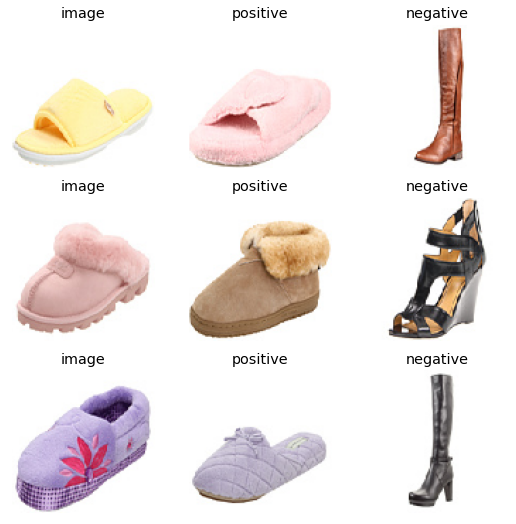

In [34]:
def show(ax, image, title):
    ax.imshow(image)
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
fig = plt.figure(figsize=(9, 9))
axs = fig.subplots(3, 3)
for i in range(3):
    show(axs[i, 0], train_paris[2*i][0], "image")
    show(axs[i, 1], train_paris[2*i][1], "positive")
    show(axs[i, 2], train_paris[2*i+1][1], "negative")

# Build Siamese Network

In [15]:
def siamese_model(shape, embedding_d=512): # instade of 48
    inputs = Input(shape)
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.5)(x)
    
    x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.5)(x)
    
#     global_pool = GlobalAveragePooling2D()(x) # instade of GlobalAveragePooling2D
    global_pool = Flatten()(x) # instade of GlobalAveragePooling2D
    
    global_pool = Dense(2048, activation="relu")(global_pool)

    outputs = Dense(embedding_d)(global_pool)
    
    model = Model(inputs, outputs)
    
    return model

In [12]:
def cal_euclidean_distance(vector_tuple):
    (vector_1, vector_2) = vector_tuple
    sqr_sum = Backend.sum(Backend.square(vector_1 - vector_2), axis=1, keepdims=True)
    distance = Backend.sqrt(Backend.maximum(sqr_sum, Backend.epsilon()))
    return distance   

In [16]:
input_1 = Input(shape=IMG_SHAPE)
input_2 = Input(shape=IMG_SHAPE)
ext_features = siamese_model(IMG_SHAPE)
features_1 = ext_features(input_1)
features_2 = ext_features(input_2)
euc_distance = Lambda(cal_euclidean_distance)([features_1, features_2])
sia_model = Model(inputs=[input_1, input_2], outputs=euc_distance)
sia_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 102, 102, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 102, 102, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 512)          82988416    input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_2[1][0]              

In [17]:
ext_features.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 102, 102, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 102, 102, 64)      832       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 51, 51, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 51, 51, 64)        16448     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25, 25, 64)        0   

# Trianing Model 

In [19]:
def cal_loss(y, pred, margin=1):
    y = tf.cast(y, pred.dtype)
    square = Backend.square(pred)
    margin_square = Backend.square(Backend.maximum(margin - pred, 0))
    loss = Backend.mean(y * square + (1 - y) * margin_square)
    return loss

In [20]:
sia_model.compile(loss=cal_loss, optimizer="adam")

start_time = time.time()

history = sia_model.fit(
    [train_paris[:, 0], train_paris[:, 1]], train_labels[:],
    validation_data=([val_paris[:, 0], val_paris[:, 1]], val_labels[:]),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/32
290/290 [==============================] - 10s 34ms/step - loss: 0.8434 - val_loss: 0.4961
Epoch 2/32
290/290 [==============================] - 10s 33ms/step - loss: 0.1630 - val_loss: 0.4652
Epoch 3/32
290/290 [==============================] - 10s 33ms/step - loss: 0.1414 - val_loss: 0.4311
Epoch 4/32
290/290 [==============================] - 10s 34ms/step - loss: 0.1320 - val_loss: 0.2172
Epoch 5/32
290/290 [==============================] - 10s 33ms/step - loss: 0.1171 - val_loss: 0.1944
Epoch 6/32
290/290 [==============================] - 10s 33ms/step - loss: 0.1048 - val_loss: 0.1590
Epoch 7/32
290/290 [==============================] - 10s 33ms/step - loss: 0.0952 - val_loss: 0.1780
Epoch 8/32
290/290 [==============================] - 10s 34ms/step - loss: 0.0861 - val_loss: 0.1894
Epoch 9/32
290/290 [==============================] - 10s 34ms/step - loss: 0.0793 - val_loss: 0.1241
Epoch 10/32
290/290 [==============================] - 10s 34ms/step - loss: 0.069

In [169]:
# print(history.history["loss"])

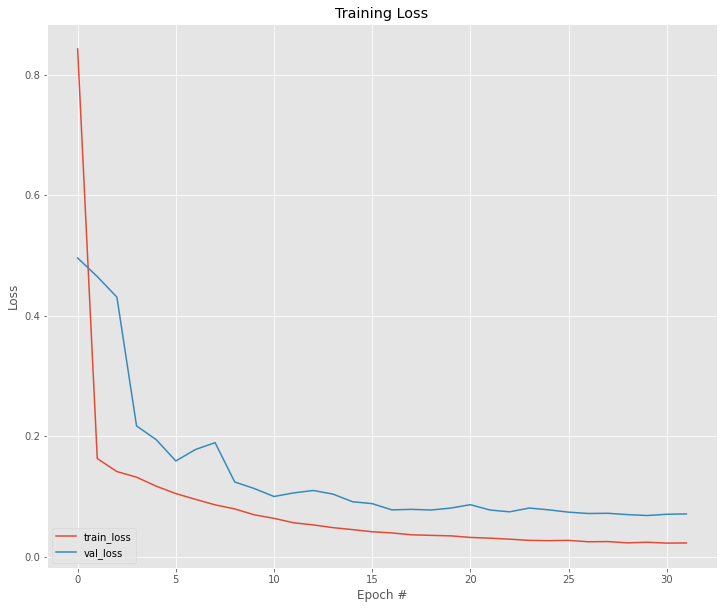

In [21]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 10))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

In [22]:
(test_paris, test_labels) = make_pos_neg_pairs(test_X, test_y)

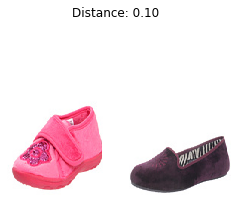

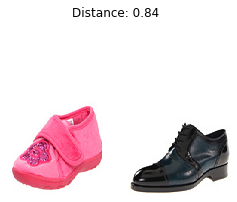

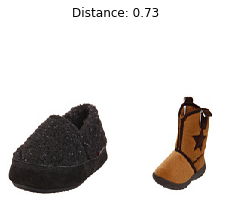

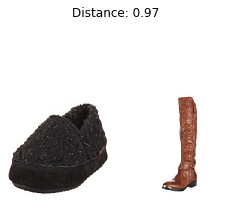

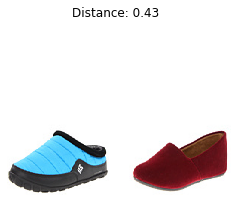

In [23]:


for i in range(5):
    imageA = np.expand_dims(test_paris[i][0], axis=0)
    imageB = np.expand_dims(test_paris[i][1], axis=0)
    preds = sia_model.predict([imageA, imageB])
    proba = preds[0][0]
    
    fig = plt.figure("Pair #{}".format(i + 1), figsize=(4, 4))
    plt.suptitle("Distance: {:.2f}".format(proba))
    
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(test_paris[i][0])
    plt.axis("off")
    
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(test_paris[i][1])
    plt.axis("off")
    
    plt.show()
    

# Single layer classifier

In [25]:
# train_fetures = ext_features(train_X)

train_fetures = ext_features(train_X[:2000])
train_fetures2 = ext_features(train_X[2000:3500])
train_fetures3 = ext_features(train_X[3500:])

val_fetures = ext_features(val_X)
test_fetures = ext_features(test_X)

In [26]:
train_fetures0 = np.concatenate((train_fetures,train_fetures2,train_fetures3))

In [27]:
train_fetures0.shape, train_X.shape, train_y.shape

((4626, 512), (4626, 102, 102, 3), (4626,))

In [28]:
class_model = tf.keras.Sequential(name="class_model")
# class_model.add(tf.keras.layers.Dense(128, activation='relu', name="dense_layer1"))
class_model.add(tf.keras.layers.Dense(4, activation='softmax', name="predictions"))


In [29]:
from tensorflow.keras.optimizers import SGD
import time

class_model.compile(optimizer=SGD(lr=0.001, momentum=0.99), 
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                    metrics=["accuracy"]
                    )

start_time = time.time()

hist = class_model.fit(x=train_fetures0, y= train_y, 
                          epochs=90, 
                          validation_data=(val_fetures, val_y),
)

print(f"\nTrained for {(time.time() - start_time) / 60} minutes ")

Epoch 1/90
145/145 [==============================] - 0s 2ms/step - loss: 1.2140 - accuracy: 0.8403 - val_loss: 0.9995 - val_accuracy: 0.9031
Epoch 2/90
145/145 [==============================] - 0s 2ms/step - loss: 0.7159 - accuracy: 0.9935 - val_loss: 0.6078 - val_accuracy: 0.9325
Epoch 3/90
145/145 [==============================] - 0s 2ms/step - loss: 0.3940 - accuracy: 0.9965 - val_loss: 0.4222 - val_accuracy: 0.9412
Epoch 4/90
145/145 [==============================] - 0s 2ms/step - loss: 0.2517 - accuracy: 0.9959 - val_loss: 0.3399 - val_accuracy: 0.9377
Epoch 5/90
145/145 [==============================] - 0s 2ms/step - loss: 0.1851 - accuracy: 0.9961 - val_loss: 0.2978 - val_accuracy: 0.9360
Epoch 6/90
145/145 [==============================] - 0s 2ms/step - loss: 0.1487 - accuracy: 0.9959 - val_loss: 0.2727 - val_accuracy: 0.9377
Epoch 7/90
145/145 [==============================] - 0s 2ms/step - loss: 0.1259 - accuracy: 0.9961 - val_loss: 0.2557 - val_accuracy: 0.9377
Epoch 

In [33]:
from sklearn.metrics import classification_report

# encode the test data
# y_pred = model5.predict(test_ds)
y_pred = class_model.predict(test_fetures)


# calculate classification accuracy
report = classification_report(test_y, np.argmax(y_pred, axis=1), target_names=class_names, digits=4)
print(report)

print('---------------------------------------')

              precision    recall  f1-score   support

    Slippers     0.8790    0.8450    0.8617       129
     Sandals     0.9006    0.9667    0.9325       150
       Boots     0.9740    1.0000    0.9868       150
       Shoes     0.9500    0.8867    0.9172       150

    accuracy                         0.9275       579
   macro avg     0.9259    0.9246    0.9246       579
weighted avg     0.9276    0.9275    0.9268       579

---------------------------------------



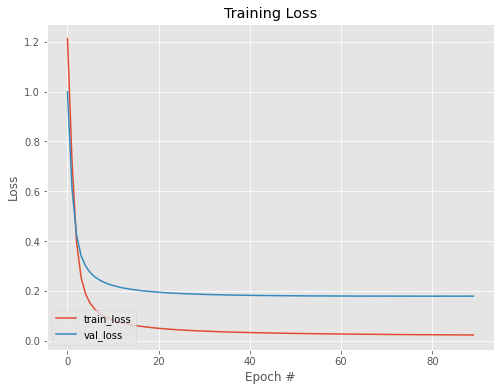

In [31]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(hist.history["loss"], label="train_loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

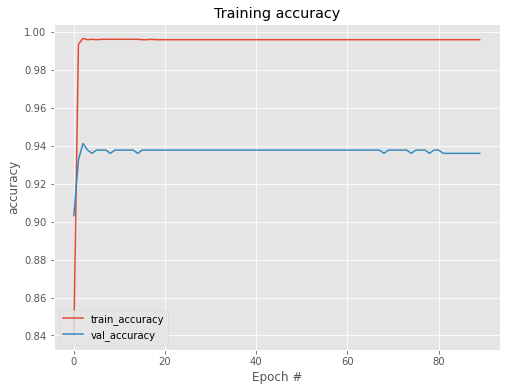

In [32]:
plt.style.use("ggplot")
plt.figure(figsize=(8, 6))
plt.plot(hist.history["accuracy"], label="train_accuracy")
plt.plot(hist.history["val_accuracy"], label="val_accuracy")
plt.title("Training accuracy")
plt.xlabel("Epoch #")
plt.ylabel("accuracy")
plt.legend(loc="lower left")